# Things to install
```bash
# batman  
pip install git+https://github.com/lkreidberg/batman  
# corner  
pip install corner  
# pygtc  
pip install pygtc  
# exoparams  
pip install git+https://github.com/bmorris3/exoparams  
# termcolor  
pip install termcolor  
# lmfit  
pip install git+https://github.com/exowanderer/lmfit-py  
# skywalker  
pip install git+https://github.com/munozcar/SKYWALKER  
# emcee  
pip install git+https://github.com/dfm/emcee  
```

In [1]:
import numpy as np
# import batman
import corner
import argparse
# import exoparams
import exomast_api # github.com/exowanderer/exomast_api
import json
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from os import environ
from pandas import DataFrame
from scipy import special
from sklearn.externals import joblib
from functools import partial
from lmfit import Parameters, Minimizer, report_errors
from multiprocessing import cpu_count, Pool
from scipy import spatial
from statsmodels.robust import scale
from time import time
from termcolor import colored
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

# SKYWALKER methods and assisting routines:
import skywalker
from skywalker import utils
from skywalker import models
from skywalker import bliss
from skywalker import krdata as kr
from skywalker import pld
from skywalker.utils import plot_fit_residuals_physics

In [24]:
json_dir = '/Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/'
json_planet_file = 'qatar2_planet_params.json'
# method = 'bliss' # BLISS SELF-CALIBRATION SETTING
# method = 'krdata' # KRDATA SELF-CALIBRATION SETTING
method = 'pld'; pld_order = 3 # PLD SELF-CALIBRATION SETTING

channel = 'ch1' # CHANNEL SETTING
staticRad = 2.5
varRad = 0.0
base_dir = '/Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/WandererOuput/'
dataDir = base_dir + 'qatar2_full_output_for_pipeline_{}_{:.1f}_{:.1f}.joblib.save'.format(channel, staticRad, varRad)

save_dir = '/Users/jonathan/Research/Planets/PhaseCurves/Keep_For_Now/'

x_bin_size = 0.01
y_bin_size = 0.01
do_mcmc = False

In [19]:
planet_info = exomast_api.exoMAST_API(planet_name='Qatar-2 b')

In [20]:
# Global constants.
y,x = 0,1
ppm = 1e6
day_to_seconds = 86400
zero = 0.0

# color_cycle =  plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fit_type = {True: 'mcmc', False:'mle'}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [21]:
# transit_type='secondary'
x_sigma_range = 4
y_sigma_range = 4
f_sigma_range = 4

In [22]:
init_u1, init_u2, init_u3, init_u4, init_fpfs = None, None, None, None, None

use_json = False
if use_json:
    with open(planet_name, 'r') as file_in:
        planet_json = json.load(file_in)
    init_period = planet_json['period']
    init_t0     = planet_json['t0']
    init_aprs   = planet_json['aprs']
    init_inc    = planet_json['inc']
    
    if 'tdepth' in planet_json.keys():
        init_tdepth   = planet_json['tdepth']
    elif 'rprs' in planet_json.keys():
        init_tdepth   = planet_json['rprs']**2
    elif 'rp' in planet_json.keys():
        init_tdepth   = planet_json['rp']**2
    else:
        raise ValueError("Either `tdepth` or `rprs` or `rp` (in relative units) \
                            must be included in {}".format(planet_name))
    
    init_fpfs   = planet_json['fpfs'] if 'fpfs' in planet_json.keys() else 2000 / ppm
    init_ecc    = planet_json['ecc']
    init_omega  = planet_json['omega']
    init_u1     = planet_json['u1'] if 'u1' in planet_json.keys() else None
    init_u2     = planet_json['u2'] if 'u2' in planet_json.keys() else None
    init_u3     = planet_json['u3'] if 'u3' in planet_json.keys() else None
    init_u4     = planet_json['u4'] if 'u4' in planet_json.keys() else None
    
    if 'planet name' in planet_json.keys():
        planet_name = planet_json['planet name']
    else:
        # Assume the json file name is the planet name
        #   This is a bad assumption; but it is one that users will understand
        print("'planet name' is not inlcude in {};".format(planet_name), end=" ")
        planet_name = planet_name.split('.json')[0]
        print(" assuming the 'planet name' is {}".format(planet_name))
else:
    init_period = planet_info.orbital_period
    init_t0     = planet_info.transit_time
    init_aprs   = planet_info.a_Rs
    init_inc    = planet_info.inclination
    
    init_tdepth = planet_info.transit_depth
    init_ecc = planet_info.eccentricity
    init_omega = planet_info.omega

init_fpfs = 5000 / ppm if init_fpfs is None else init_fpfs
init_u1   = 0.1 if init_u1 is None else init_u1
init_u2   = 1e-6 if init_u2 is None else init_u2
init_u3   = 1e-6 if init_u3 is None else init_u3
init_u4   = 1e-6 if init_u4 is None else init_u4

In [25]:
print('Acquiring Data')

data_in = utils.setup_inputs_from_file(dataDir, x_bin_size=x_bin_size, y_bin_size=y_bin_size, xSigmaRange=x_sigma_range, 
                                       ySigmaRange=y_sigma_range, fSigmaRange=f_sigma_range, flux_key='phots', 
                                       time_key='times', flux_err_key='noise', eff_width_key = 'npix', 
                                       pld_coeff_key = 'pld', ycenter_key='ycenters', xcenter_key='xcenters', 
                                       ywidth_key='ywidths', xwidth_key='xwidths', method=method)

fluxes, times, flux_errs, npix, pld_intensities0, xcenters, ycenters, xwidths, ywidths, \
    knots, nearIndices, keep_inds, ind_kdtree, gw_kdtree = data_in

# Only use the valid values
fluxes = fluxes[keep_inds]
times = times[keep_inds]
flux_errs = flux_errs[keep_inds]
npix = npix[keep_inds]
xcenters = xcenters[keep_inds]
ycenters = ycenters[keep_inds]
xwidths = xwidths[keep_inds]
ywidths = ywidths[keep_inds]

# Normalize fluxes and flux errors around 1
flux_errs = flux_errs/np.median(fluxes)
fluxes = fluxes/np.median(fluxes)

Acquiring Data
Setting up inputs for pld.
Using PLD


In [26]:
print('Fixing Time Stamps')
len_init_t0 = len(str(int(init_t0)))
len_times = len(str(int(times.mean())))

# Check if `init_t0` is in JD or MJD
if len_init_t0 == 7 and len_times != 7:
    if len_times == 5:
        init_t0 = init_t0 - 2400000.5
    elif len_times == 4:
        init_t0 = init_t0 - 2450000.5
    else:
        raise ValueError('The `init_t0` is {} and `times.mean()` is {}'.format(int(init_t0), int(times.mean())))

# Check if `init_t0` is in MJD or Simplified-MJD
if len(str(int(init_t0))) > len(str(int(times.mean()))): init_t0 = init_t0 - 50000

Fixing Time Stamps


# Begin Fitting Procedures

In [27]:
time_stamp = datetime.utcnow().strftime("%Y%m%d%H%M%S")

In [108]:
nSig = 10
max_phase = 0.5*init_period#90/180*np.pi

print('Initializing Parameters')
initialParams = Parameters()
initialParams.add_many(
    ('period', init_period, False), #, init_period, init_period), # maybe set this to make MCMC static
    ('deltaTc', 1e-3, True, -0.025, 0.025),
    # ('deltaEc', 1e-3, True, -0.025, 0.025),
    ('deltaEc', 0.0, False, -0.05, 0.05),
    ('inc', init_inc, False, 80.0, 90.),
    ('aprs', init_aprs, False, 0.0, 100.),
    ('tdepth', init_tdepth, True, 0.0, 0.3 ), 
    ('edepth', init_fpfs, True, 0.0, 0.1),
    ('ecc', init_ecc, False, 0.0, 1.0 ),
    ('omega', init_omega, False, -180, 180 ),
    ('u1', init_u1 , True, 0.0, 1.0 ),
    # ('u2', init_u2 , True, 0.0, 1.0 ),
    ('u2', 0.0 , False, 0.0, 1.0 ),
    ('Y_1n1', 1e-3, True, -5, 5),
    ('Y_1_0', 1e-3, True, -5, 5),
    ('Y_1p1', 1e-3, True, -5, 5),
#     ('night_flux', 1e-5, True, -1.0, 1.0),
    ('tCenter', init_t0 , False),
    ('intercept', 1.00 , False, 1-np.std(fluxes)*nSig, 1+np.std(fluxes)*nSig),
    ('slope', 1e-4, True),
    ('curvature', 1e-6 , False))

if channel == 'ch1' and planet_name == 'Qatar-2b':
    print("Adding Weirdness")
    initialParams.add_many(('t_start', 0.135, True, 0.125, 0.150),
                           ('weirdintercept', 1-0.01, True),
                           ('weirdslope', 0.01, True)
                          )

add_unity = True
n_ppm = 1.0
verbose = False
do_pca = True
do_ica = False
do_std = True
pca_cut = True
start_unity = False
# Normalize pld pixel values and estimate initial parameters
if method.lower() == 'pld':
    pldints = [pld_now[keep_inds] for pld_now in pld_intensities0]
    pld_intensities = pld.normalize_pld(np.array(pldints))
    
    n_pld, _ = pld_intensities.shape
    
    if verbose: print('Initializing PLD coefficients.')
    initialParams, pld_intensities = models.add_pld_params(initialParams, fluxes=fluxes, pld_intensities=pld_intensities0, 
                                                           add_unity=add_unity, n_pld=n_pld, n_ppm=n_ppm, order=pld_order, 
                                                           verbose=verbose, do_pca=do_pca, do_ica=do_ica, do_std=do_std, 
                                                           pca_cut=pca_cut, start_unity=start_unity)
    
    drop_linear_correlations = False
    if drop_linear_correlations and 'pld' in method.lower() and pld_order is 3 and bool(add_unity*pca_cut):
        if channel is 'ch1':
            # These were found to have linear correlations close (or equal) to one!
            pld_drop_keys_because_of_strong_correlations = []#['pld8', 'pld6', 'pld11', 'pld15']#, pld10, pld4, pld9
            
            keep_params = [val for val in initialParams.values() if val.name.lower() not in pld_drop_keys_because_of_strong_correlations]
        elif channel is 'ch2':
            # These were found to have linear correlations close to one!
            pld_drop_keys_because_of_strong_correlations = ['pld2', 'pld3', 'pld7', 'pld9', 'pld11']
            
            keep_params = [val for val in initialParams.values() if val.name.lower() not in pld_drop_keys_because_of_strong_correlations]
        else:
            assert('Channel must be either `ch1` or `ch2`.')
        
        initialParams = Parameters()
        initialParams.add_many(*keep_params)
    else:
        pld_drop_keys_because_of_strong_correlations = []
    
    pld_drop_idx_because_of_strong_correlations = [int(key[len('pld'):]) for key in pld_drop_keys_because_of_strong_correlations]
    pld_intensities = np.array([val for k, val in enumerate(pld_intensities) if k not in pld_drop_idx_because_of_strong_correlations])
else:
    pld_intensities = pld_intensities0.copy()

print()
for val in initialParams.values(): print('{:15}: {:23}\t[{:5}, {:5}]\t{}'.format(val.name, str(val.value), str(val.min)[:5], 
                                                                                    str(val.max)[:5], colored(val.vary, {False:'red', True:'green'}[val.vary])))

Initializing Parameters
Adding Weirdness

period         : 1.33711677             	[-inf , inf  ]	False
deltaTc        : 0.001                  	[-0.02, 0.025]	True
deltaEc        : 0.0                    	[-0.05, 0.05 ]	False
inc            : 88.99                  	[80.0 , 90.0 ]	False
aprs           : 6.51466                	[0.0  , 100.0]	False
tdepth         : 0.0266587              	[0.0  , 0.3  ]	True
edepth         : 0.002                  	[0.0  , 0.1  ]	True
ecc            : 0.0                    	[0.0  , 1.0  ]	False
omega          : 180.0                  	[-180 , 180  ]	False
u1             : 0.1                    	[0.0  , 1.0  ]	True
u2             : 0.0                    	[0.0  , 1.0  ]	False
cosAmp         : 0.001                  	[0    , 1    ]	True
cosPhase       : 0.001                  	[-0.66, 0.668]	True
night_flux     : 1e-05                  	[-1.0 , 1.0  ]	True
tCenter        : 57249.700815500226     	[-inf , inf  ]	False
intercept      : 1.0               

Establishing the init Solution
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Keep_For_Now/Qatar-2b_ch1_2.5_0.0_pld_init_fit_residuals_physics_20181007193041.png


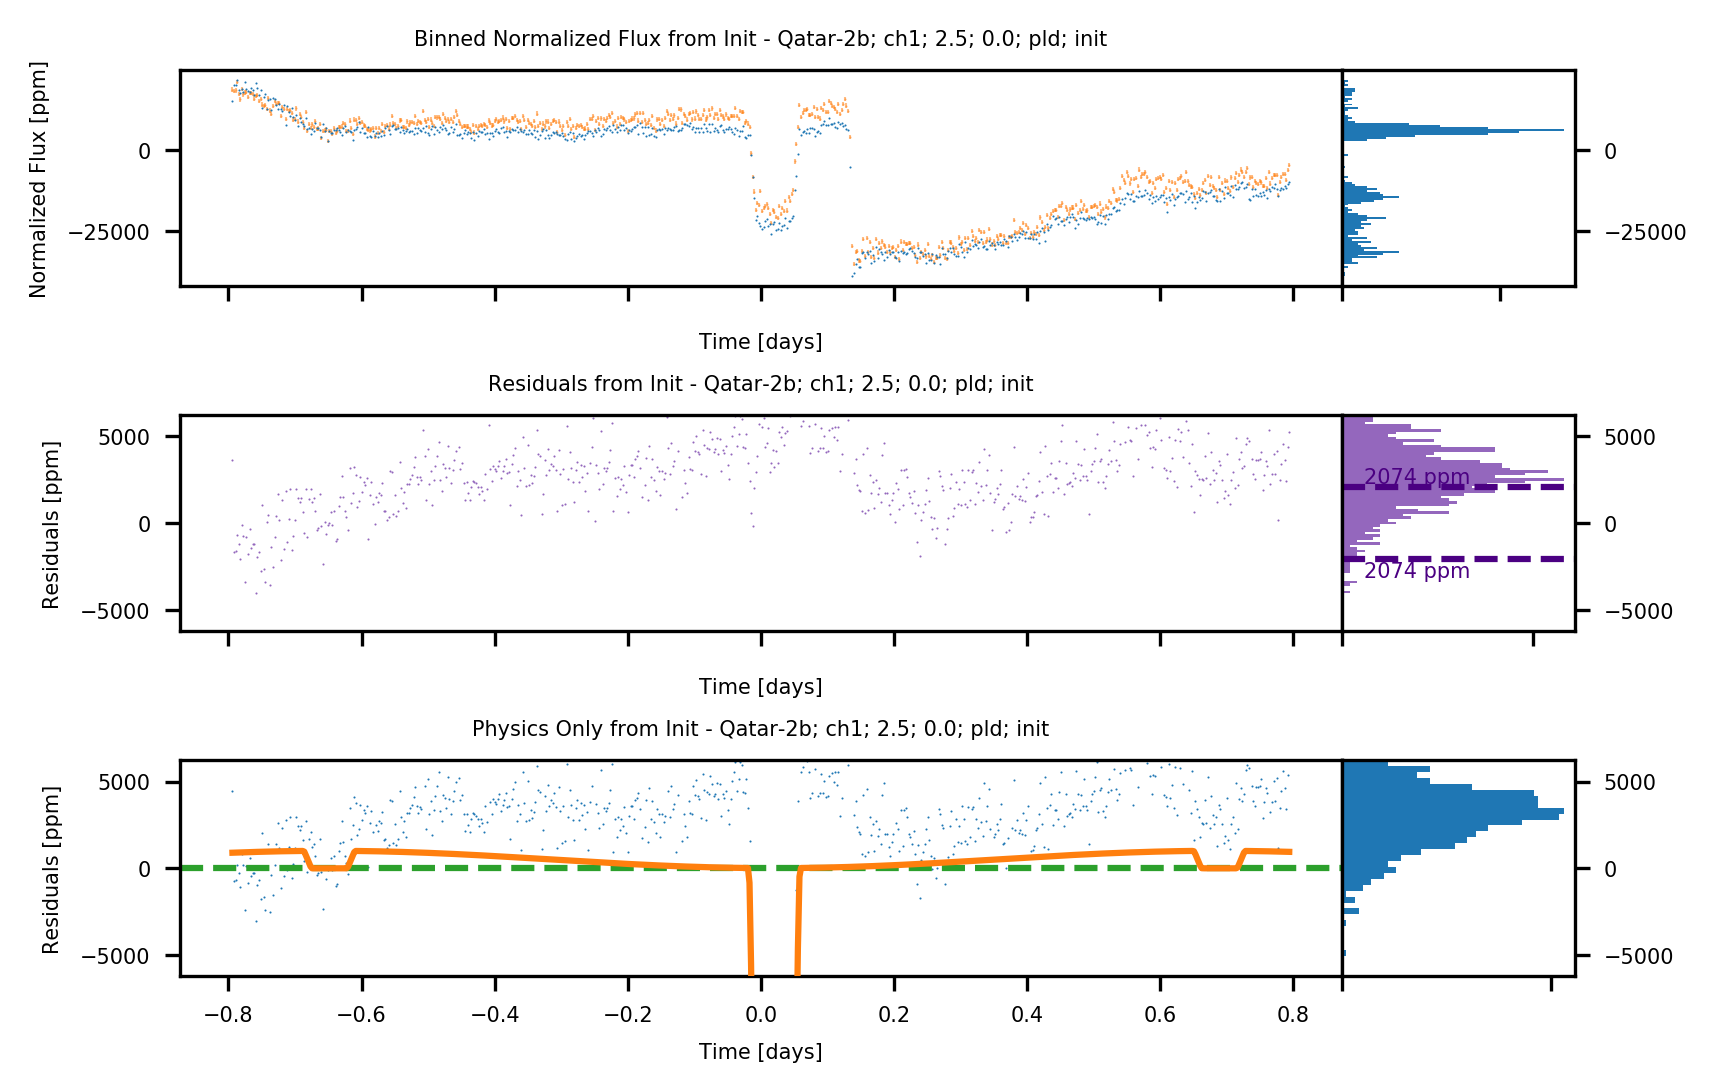

In [111]:
init_model_set = skywalker.generate_best_fit_solution(  model_params = initialParams, 
                                                    times = times, 
                                                    xcenters = xcenters, 
                                                    ycenters = ycenters, 
                                                    fluxes = fluxes, 
                                                    knots = knots, 
                                                    keep_inds = keep_inds, 
                                                    method = method, 
                                                    nearIndices = nearIndices, 
                                                    ind_kdtree = ind_kdtree, 
                                                    gw_kdtree = gw_kdtree, 
                                                    pld_intensities = pld_intensities, 
                                                    x_bin_size = x_bin_size, 
                                                    y_bin_size = y_bin_size, 
                                                    eclipse_option = 'trapezoid')
bin_size = 100
plot_fit_residuals_physics(times, fluxes, flux_errs, init_model_set, planet_name=planet_name, channel=channel, 
                           staticRad=staticRad, varRad=varRad, method=method, plot_name='init', bin_size=bin_size,
                           time_stamp=time_stamp, save_now=True, save_dir=save_dir)

In [112]:
partial_residuals  = partial(skywalker.residuals_func,
                             times = times,
                             xcenters = xcenters,
                             ycenters = ycenters,
                             fluxes = fluxes,
                             flux_errs = flux_errs,
                             knots = knots,
                             nearIndices = nearIndices,
                             keep_inds = keep_inds,
                             ind_kdtree = ind_kdtree,
                             pld_intensities = pld_intensities,
                             method = method.lower(),
                             gw_kdtree = gw_kdtree,
                             x_bin_size = x_bin_size,
                             y_bin_size = y_bin_size, 
                             include_transit = True, 
                             include_eclipse = True, 
                             include_phase_curve = True, 
                             include_polynomial = True,
                             eclipse_option = 'trapezoid')

In [113]:
print('Fitting the Model')
# Setup up the call to minimize the residuals (i.e. ChiSq)
mle0  = Minimizer(partial_residuals, initialParams, nan_policy = 'omit')

start = time()
fitResult = mle0.leastsq(initialParams) # Go-Go Gadget Fitting Routine
print("LMFIT operation took {} seconds".format(time()-start))

mle_save_name = '{}_{}_{}_{}_{}_{}_fit_residuals_physics_{}.joblib.save'.format(planet_name.replace(' b','b'), channel, staticRad, varRad, method, 
                                                                                    fit_type[False], time_stamp)
print('Saving MLE tp {}'.format(mle_save_name))
joblib.dump(fitResult, save_dir + mle_save_name)

report_errors(fitResult.params)

Fitting the Model
LMFIT operation took 17.641155004501343 seconds
Saving MLE tp Qatar-2b_ch1_2.5_0.0_pld_mle_fit_residuals_physics_20181007193041.joblib.save
[[Variables]]
    period:          1.337117 (fixed)
    deltaTc:         1.8544e-04 (init = 0.001)
    deltaEc:         0 (fixed)
    inc:             88.99 (fixed)
    aprs:            6.51466 (fixed)
    tdepth:          0.02752166 (init = 0.0266587)
    edepth:          0.00172876 (init = 0.00101)
    ecc:             0 (fixed)
    omega:           180 (fixed)
    u1:              0.17189217 (init = 0.1)
    u2:              0 (fixed)
    cosAmp:          4.1067e-09 (init = 0.001)
    cosPhase:        0.66771577 (init = 0.001)
    night_flux:      0.00172876 (init = 1e-05)
    tCenter:         57249.7 (fixed)
    intercept:       1 (fixed)
    slope:          -0.00423419 (init = 0.0001)
    curvature:       1e-06 (fixed)
    t_start:         0.13500000 (init = 0.135)
    weirdintercept:  0.96673135 (init = 0.99)
    weirdslope:

In [114]:
for val in fitResult.params.values(): print('{:15}: {:23}\t[{:5}, {:5}]\t{}'.format(val.name, str(val.value), str(val.min)[:5], 
                                                                                    str(val.max)[:5], colored(val.vary, {False:'red', True:'green'}[val.vary])))

period         : 1.33711677             	[-inf , inf  ]	False
deltaTc        : 0.00018544158021389576 	[-0.02, 0.025]	True
deltaEc        : 0.0                    	[-0.05, 0.05 ]	False
inc            : 88.99                  	[80.0 , 90.0 ]	False
aprs           : 6.51466                	[0.0  , 100.0]	False
tdepth         : 0.027521655236457665   	[0.0  , 0.3  ]	True
edepth         : 0.001728760092382986   	[0.0  , 0.1  ]	True
ecc            : 0.0                    	[0.0  , 1.0  ]	False
omega          : 180.0                  	[-180 , 180  ]	False
u1             : 0.1718921676713822     	[0.0  , 1.0  ]	True
u2             : 0.0                    	[0.0  , 1.0  ]	False
cosAmp         : 4.1067203526701235e-09 	[0    , 1    ]	True
cosPhase       : 0.6677157727938762     	[-0.66, 0.668]	True
night_flux     : 0.0017287600747735166  	[-1.0 , 1.0  ]	True
tCenter        : 57249.700815500226     	[-inf , inf  ]	False
intercept      : 1.0                    	[0.817, 1.182]	False
slope          

Establishing the mle Solution
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Keep_For_Now/Qatar-2b_ch1_2.5_0.0_pld_mle_fit_residuals_physics_20181007193041.png


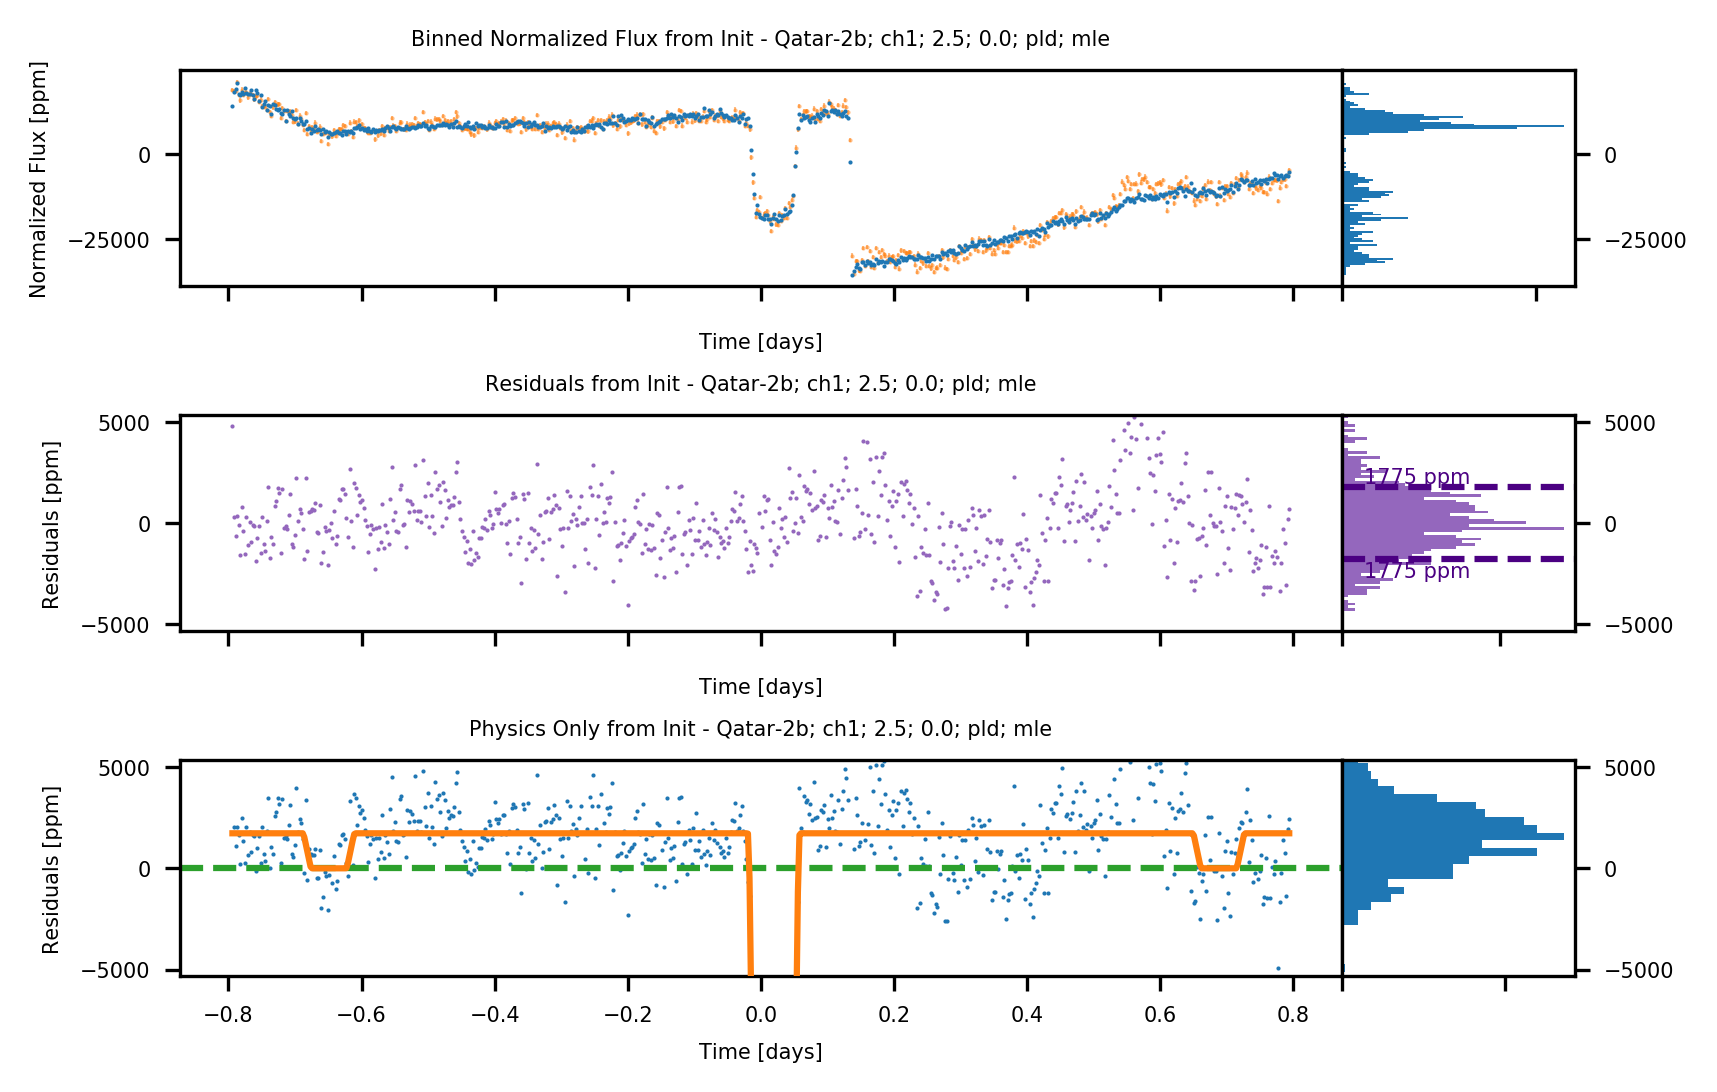

In [115]:
mle_model_set = skywalker.generate_best_fit_solution(   model_params = fitResult.params, 
                                                    times = times, 
                                                    xcenters = xcenters, 
                                                    ycenters = ycenters, 
                                                    fluxes = fluxes, 
                                                    knots = knots, 
                                                    keep_inds = keep_inds, 
                                                    method = method, 
                                                    nearIndices = nearIndices, 
                                                    ind_kdtree = ind_kdtree, 
                                                    gw_kdtree = gw_kdtree, 
                                                    pld_intensities = pld_intensities, 
                                                    x_bin_size = x_bin_size, 
                                                    y_bin_size = y_bin_size, 
                                                    eclipse_option = 'trapezoid')

bin_size = 100
plot_fit_residuals_physics(times, fluxes, flux_errs, mle_model_set, plot_name='mle', planet_name=planet_name, 
                           channel=channel, staticRad=staticRad, varRad=varRad, method=method, bin_size=bin_size, 
                           markersize=2,time_stamp=time_stamp, save_now=True, save_dir=save_dir)

option1: with weird slope/intercept, no curvature  
option2: with weird slope/intercept, with curvature  
option3: no weird slope/intercept, with curvature  
option4: no weird slope/intercept, no curvature  

In [87]:
print(aic2 - aic1, aic3 - aic1, aic4 - aic1)
print(bic2 - bic1, bic3 - bic1, bic4 - bic1)

-87.4748657222226 9209.938631224788 12071.735115859083
-78.35267440076132 9191.694248581858 12044.368541894692


In [ ]:
nSig = 10
do_mcmc = True
new_mcmc = True
warm_start = False

if do_mcmc and new_mcmc:
    print('Setting up EMCEE')
    fitResult.params.add('err_mod', value=1, min=1e-4, max=10)
    
    def logprior_func(p):
        for key, val in p.items():
            # Uniform Prior
            if val.min >= val.value >= val.max: return -np.inf
        
        # Establish that the limb darkening parameters 
        #  cannot sum to 1 or greater
        #  Kipping et al 201? and Espinoza et al 201?
        if 'u1' in p.keys() and 'u2' in p.keys():
            if p['u1'] + p['u2'] >= 1: return -np.inf
        
        return 0
    
    def lnprob(p):
        logprior = logprior_func(p)
        if not np.isfinite(logprior):
            return -np.inf
        
        resid = partial_residuals(p)
        
        s = p['err_mod']
        resid *= 1 / s
        resid *= resid
        resid += np.log(2 * np.pi * s**2)
        
        return -0.5 * np.sum(resid) + logprior
    
    mini  = Minimizer(lnprob, fitResult.params, nan_policy='omit')
    
    if warm_start:
        try:
            emcee_params_in = res.params # warm start
        except:
            print("[WARNING]: `warm_start` is True; but `res.params` does not exists. Creating NEW `res.params` now!")
            emcee_params_in = fitResult.params
    else:
        emcee_params_in = fitResult.params
    
    print('Starting from Existing `res.params`' if warm_start else 'Starting Fresh')
    
    n_steps = 1000
    n_walkers = 1000
    n_burn = int(n_steps*0.2)
    n_thin = 10
    n_temps = 1
    starting_values = np.array([val.value for val in emcee_params_in.values() if val.vary])
    pos = np.random.normal(starting_values, 1e-2*abs(starting_values), (n_walkers, len(starting_values))) if warm_start else None
    reuse_sampler = False
    n_workers = cpu_count()#-1
    is_weighted = True
    seed = None# 42
    
    start = time()
    
    print('MCMC routine in progress...') # FINDME: Using `res.params` to start the new MCMC from the old MCMC (mega-burnin)
    res   = mini.emcee(params=emcee_params_in, steps=n_steps, nwalkers=n_walkers, burn=n_burn, thin=n_thin, ntemps=n_temps,
                       pos=pos, reuse_sampler=reuse_sampler, workers=n_workers,
                       is_weighted=is_weighted, seed=seed)#, progress=True)
    
    print("MCMC operation took {} seconds".format(time()-start))
    
    mcmc_save_name = '{}_{}_{}_{}_{}_{}_{}steps_{}walkers_{}.joblib.save'.format(planet_name.replace(' ',''), channel, staticRad, varRad, method, 
                                                                    'mcmc', n_steps, n_walkers, time_stamp)
    
    print('Saving MCMC Results to {}'.format(save_dir + mcmc_save_name))
    joblib.dump(res, save_dir + mcmc_save_name)
elif do_mcmc:
    method = None
    n_steps = None
    time_stamp_backup = None
    
    emcee_save_name = '{}_{}_{}_{}_{}_{}_{}steps_{}.joblib.save'.format(planet_name, channel, staticRad, varRad, method, 
                                                                    fit_type[True], n_steps , time_stamp_backup)
    
    print('Loading EMCEE from {}'.format(save_dir + emcee_save_name))
    res = joblib.load(save_dir + emcee_save_name)

Setting up EMCEE
Starting Fresh
MCMC routine in progress...


 40%|███▉      | 399/1000 [59:59<1:34:37,  9.45s/it]

In [ ]:
report_errors(res.params)

In [ ]:
if do_mcmc:
    mcmc_model_set = skywalker.generate_best_fit_solution(  model_params = res.params, 
                                                        times = times, 
                                                        xcenters = xcenters, 
                                                        ycenters = ycenters, 
                                                        fluxes = fluxes, 
                                                        knots = knots, 
                                                        keep_inds = keep_inds, 
                                                        method = method, 
                                                        nearIndices = nearIndices, 
                                                        ind_kdtree = ind_kdtree, 
                                                        gw_kdtree = gw_kdtree, 
                                                        pld_intensities = pld_intensities, 
                                                        x_bin_size = x_bin_size, 
                                                        y_bin_size = y_bin_size)
    bin_size = 100
    plot_name = 'mcmc_{}_{}'.format(n_steps, n_walkers)
    plot_fit_residuals_physics(times, fluxes, flux_errs, mcmc_model_set, plot_name=plot_name,planet_name=planet_name, 
                               channel=channel, staticRad=staticRad, varRad=varRad, method=method, bin_size=bin_size,
                               time_stamp=time_stamp, save_now=True, save_dir=save_dir, markersize=3)

In [ ]:
if do_mcmc:
    res_var_names = np.array(res.var_names)
    res_flatchain = np.array(res.flatchain)
    res_df = DataFrame(res_flatchain.copy(), columns=res_var_names)
    
    # Do not corner plot the PLD coefficients directly.
    if method is 'pld': res_df.drop([vname for vname in res_var_names if 'pld' in vname], axis=1, inplace=True)
    
    res_df.sort_index('columns', inplace=True)
    # res_df = res_df.drop(['u2','slope'], axis=1)
    res_df['edepth'] = res_df['night_flux'] + res_df['cosAmp']*np.cos(res_df['cosPhase'])
    # nSig = 6
    # ranges = [(np.mean(val) - nSig*np.std(val), np.mean(val) - nSig*np.std(val)) for key,val in res_df.items()]
    
    def add_newline(label): return label + '\n'
    
    color = 'indigo'
    
    n_sigma = 3
    levels = [0.682689492137, 0.954499736104, 0.997300203937, 0.999936657516, 0.999999426697, 0.999999998027]
    
    title_kwargs = dict(columnwise = True)
    
    corner_kwargs = {}
    corner_kwargs['color'] = color
    corner_kwargs['labels'] = list(map(add_newline,res_df.columns))
    corner_kwargs['plot_datapoints'] = False
    corner_kwargs['bins'] = 50
    corner_kwargs['plot_density'] = False
    corner_kwargs['smooth'] = True
    corner_kwargs['fill_contours'] = True
    corner_kwargs['levels'] = levels[:n_sigma]
    corner_kwargs['show_titles'] = True
    corner_kwargs['title_fmt'] = '0.2e'
    corner_kwargs['columnwise_titles'] = True
    corner_kwargs['title_kwargs'] = dict(fontsize=20)
    
    corner.corner(res_df, **corner_kwargs)
    
    corner_save_name = '{}_{}_{}_{}_{}_{}_emcee_cornerplot_{}.png'.format(planet_name.replace(' b','b'), channel, staticRad, 
                                                                          varRad, method, fit_type[do_mcmc], time_stamp)
    print('Saving corner plot to {}'.format(corner_save_name))
    plt.savefig(save_dir + corner_save_name)

In [ ]:
res_df.describe()

In [ ]:
if do_mcmc and method is 'pld':
    res_var_names = np.array(res.var_names)
    res_flatchain = np.array(res.flatchain)
    res_df = DataFrame(res_flatchain.copy(), columns=res_var_names)
    
    # Do not corner plot the PLD coefficients directly.
    res_df = res_df[[vname for vname in res_var_names if 'pld' in vname]]
    
    def add_newline(label): return label + '\n'
    
    color = 'indigo'
    
    n_sigma = 3
    levels = [0.682689492137, 0.954499736104, 0.997300203937, 0.999936657516, 0.999999426697, 0.999999998027]
    
    title_kwargs = dict(columnwise = True)
    
    corner_kwargs = {}
    corner_kwargs['color'] = color
    corner_kwargs['labels'] = list(map(add_newline,res_df.columns))
    corner_kwargs['plot_datapoints'] = False
    corner_kwargs['bins'] = 50
    corner_kwargs['plot_density'] = False
    corner_kwargs['smooth'] = True
    corner_kwargs['fill_contours'] = True
    corner_kwargs['levels'] = levels[:n_sigma]
    corner_kwargs['show_titles'] = True
    corner_kwargs['title_fmt'] = '0.2e'
    corner_kwargs['columnwise_titles'] = True
    corner_kwargs['title_kwargs'] = dict(fontsize=20)
    
    corner.corner(res_df, **corner_kwargs)
    
    corner_save_name = '{}_{}_{}_{}_{}_{}_PLDCoeffs_emcee_cornerplot_{}.png'.format(planet_name.replace(' b','b'), channel, staticRad, 
                                                                          varRad, method, fit_type[do_mcmc], time_stamp)
    print('Saving PLD corner plot to {}'.format(corner_save_name))
    plt.savefig(save_dir + corner_save_name)

In [ ]:
res_df.describe()

# Testing RMS vs Binsize

In [ ]:
full_model = mcmc_model_set['full_model']
line_model = mcmc_model_set['line_model']
physical_model = mcmc_model_set['physical_model']
sensitivity_map = mcmc_model_set['sensitivity_map']

weirdness = mcmc_model_set['weirdness']# if channel == 'ch1' else = 1.0

residuals = fluxes - full_model

In [ ]:
mcmc_model_rms_v_bs, mcmc_bins_arr = utils.rms_vs_binsize(residuals)

In [ ]:
fig, ax = plt.subplots()
ax = utils.plot_rms_vs_binsize(mcmc_model_set, fluxes, mcmc_model_rms_v_bs, mcmc_bins_arr, label='PLD', ax=ax);

# Testing Plots